In [85]:
import numpy as np
import pandas as pd
import hvplot.pandas
from pathlib import Path
import hvplot

import datetime
from datetime import date, timedelta
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
%matplotlib inline

load_dotenv()

True

In [86]:
def fetch_data():
    """Fetches the latest prices."""
   # Set Alpaca API key and secret

    alpaca_api_key = os.getenv("ALPACA_API_KEY")
    alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")
    
    alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")
    today = date.today()
    start = date.today() - timedelta(days=120)

    # Set the tickers & timeframe
    tickers = ["SPY"]

    timeframe = "1D"

    #Get Closing prices for past 60 days

    df = alpaca.get_barset(
        tickers,
        timeframe,
        start = start,
        end = today
    ).df
    #figure out another way to clean and prep the data here - hard coded for now 
    df_clean = df['SPY']

    # Display sample data
    return df_clean

In [87]:
data = fetch_data()
data = data.reset_index()
data = data.set_index('time', drop=True)
data['close of tomorrow'] = data['close'].shift(-1)
data

,open,high,low,close,volume,close of tomorrow
time,,,,,,
2020-10-26 00:00:00-04:00,342.130,342.9800,335.62,339.415,79491839,338.25
2020-10-27 00:00:00-04:00,339.760,340.1200,337.99,338.250,50634843,326.67
2020-10-28 00:00:00-04:00,332.100,338.2483,326.13,326.670,107939571,329.99
2020-10-29 00:00:00-04:00,326.910,333.3950,325.09,329.990,74362731,326.53
2020-10-30 00:00:00-04:00,328.280,329.6900,322.60,326.530,93413096,330.21
...,...,...,...,...,...,...
2021-03-15 00:00:00-04:00,394.330,396.6850,392.03,396.470,64471980,395.94
2021-03-16 00:00:00-04:00,397.070,397.8300,395.08,395.940,65719794,397.22
2021-03-17 00:00:00-04:00,394.530,398.1200,393.30,397.220,61876016,391.41


In [88]:
# Drop Null values -- can cause error 
data.dropna(inplace=True)
data

,open,high,low,close,volume,close of tomorrow
time,,,,,,
2020-10-26 00:00:00-04:00,342.130,342.9800,335.62,339.415,79491839,338.25
2020-10-27 00:00:00-04:00,339.760,340.1200,337.99,338.250,50634843,326.67
2020-10-28 00:00:00-04:00,332.100,338.2483,326.13,326.670,107939571,329.99
2020-10-29 00:00:00-04:00,326.910,333.3950,325.09,329.990,74362731,326.53
2020-10-30 00:00:00-04:00,328.280,329.6900,322.60,326.530,93413096,330.21
...,...,...,...,...,...,...
2021-03-12 00:00:00-05:00,392.070,394.2100,391.20,394.090,56997361,396.47
2021-03-15 00:00:00-04:00,394.330,396.6850,392.03,396.470,64471980,395.94
2021-03-16 00:00:00-04:00,397.070,397.8300,395.08,395.940,65719794,397.22


In [89]:
#Calculate additional data to use as features - add to dataframe



def generate_ema_macd__RSI_signals(df):
    
    def EWMA(data, ndays):
        EMA = pd.Series(data['close'].ewm(span = ndays, min_periods = ndays - 1).mean(),
                     name = 'EWMA_' + str(ndays))
        data = data.join(EMA)
        return data

    def computeRSI (data, time_window):
        diff = data.diff(1).dropna()        # diff in one field(one day)

        #this preservers dimensions off diff values
        up_chg = 0 * diff
        down_chg = 0 * diff

        # up change is equal to the positive difference, otherwise equal to zero
        up_chg[diff > 0] = diff[ diff>0 ]

        # down change is equal to negative deifference, otherwise equal to zero
        down_chg[diff < 0] = diff[ diff < 0 ]

        # we set com=time_window-1 so we get decay alpha=1/time_window
        up_chg_avg   = up_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
        down_chg_avg = down_chg.ewm(com=time_window-1 , min_periods=time_window).mean()

        rs = abs(up_chg_avg/down_chg_avg)
        rsi = 100 - 100/(1+rs)
        return rsi


    #Calculate RSI
    df['RSI'] = computeRSI (df['close'], 14)
    # Construct a buy and sell trading signals buy -1 sell - 0 -- Add more sophistication to this -- I wanted to have a signal that says buy when RSI is between 50 -70 or oversold and sell when overbought and RSI is between 30-50
    df['RSI Overbought'] = np.where(df['RSI'] > 70, 1.0, 0.0)
    df['RSI Oversold'] = np.where(df['RSI'] < 30, 1.0, 0.0)
    df['RSI Long'] = np.where( df['RSI'] > 50, 1.0, 0.0)
    df['RSI Short'] = np.where( 50 > df['RSI'], 1.0, 0.0)
    
    # Set short and long windows
    short_window = 5
    long_window = 13

    # Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
    df['EMA 5'] = df['close'].ewm(halflife=short_window).mean()
    df['EMA 13'] = df['close'].ewm(halflife=long_window).mean()

    # Construct a crossover trading signal
    df['crossover_long_5_13'] = np.where(df['EMA 5'] > df['EMA 13'], 1.0, 0.0)
    df['crossover_short_5_13'] = np.where(df['EMA 5'] < df['EMA 13'], -1.0, 0.0)
    df['crossover_signal_5_13'] = df['crossover_long_5_13'] + df['crossover_short_5_13']

     # Set short and long windows for 9 & 21 EMA
    short_window_9 = 9
    long_window_21 = 21

    # Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
    df['EMA 9'] = df['close'].ewm(halflife=short_window_9).mean()
    df['EMA 21'] = df['close'].ewm(halflife=long_window_21).mean()

    # Construct a crossover trading signal
    df['crossover_long_9_21'] = np.where(df['EMA 9'] > df['EMA 21'], 1.0, 0.0)
    df['crossover_short_9_21'] = np.where(df['EMA 9'] < df['EMA 21'], -1.0, 0.0)
    df['crossover_signal_9_21'] = df['crossover_long_9_21'] + df['crossover_short_9_21']
    
    # Set short and long windows for 55 & 200 EMA
    short_window_55 = 55
    long_window_200 = 200

    # Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
    df['EMA 55'] = df['close'].ewm(halflife=short_window_55).mean()
    df['EMA 200'] = df['close'].ewm(halflife=long_window_200).mean()

    # Construct a crossover trading signal
    df['crossover_long_55_200'] = np.where(df['EMA 55'] > df['EMA 200'], 1.0, 0.0)
    df['crossover_short_55_200'] = np.where(df['EMA 55'] < df['EMA 200'], -1.0, 0.0)
    df['crossover_signal_55_200'] = df['crossover_long_55_200'] + df['crossover_short_55_200']

    # Set short and long windows for 200 & 800 EMA
    short_window_200 = 200
    long_window_800 = 800

    # Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
    df['EMA 200'] = df['close'].ewm(halflife=short_window_200).mean()
    df['EMA 800'] = df['close'].ewm(halflife=long_window_800).mean()

    # Construct a crossover trading signal
    df['crossover_long_200_800'] = np.where(df['EMA 200'] > df['EMA 800'], 1.0, 0.0)
    df['crossover_short_200_800'] = np.where(df['EMA 200'] < df['EMA 800'], -1.0, 0.0)
    df['crossover_signal_200_800'] = df['crossover_long_200_800'] + df['crossover_short_200_800']
    
    # Calculate MACD
    
    EMA_8 = df['close'].ewm(halflife=8).mean()
    EMA_22 = df['close'].ewm(halflife=22).mean()
    macd = EMA_8 - EMA_22
    df['MACD H'] = macd
    df['MACD Signal'] = np.where(df['MACD H'] > 0, 1.0, 0.0)
    
    return df

In [90]:
data = generate_ema_macd__RSI_signals(data)
data = data.dropna()

In [91]:
#define feauture and target values
X = data[['open', 'high', 'low', 'close', 'volume','EMA 9', 'EMA 21', 'EMA 5', 'EMA 13', 'EMA 55', 'RSI','MACD H', 'EMA 800', 'EMA 200']]
y = data[['close of tomorrow']]


X = np.array(X)
y = np.array(y)

In [92]:
# Use 70% of the data for training and the remaineder for testing
split = int(0.7 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

In [93]:
# Use the MinMaxScaler to scale data between 0 and 1.
scaler = MinMaxScaler()
X_scaler = scaler.fit(X)
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)
y_scaler = scaler.fit(y)
y_train = y_scaler.transform(y_train)
y_test = y_scaler.transform(y_test)

In [94]:
# Reshape the features data
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Print some sample data after reshaping the datasets
print (f"X_train sample values:\n{X_train[:3]} \n")
print (f"X_test sample values:\n{X_test[:3]}")

X_train sample values:
[[[0.        ]
  [0.00222772]
  [0.0136819 ]
  [0.04751671]
  [0.0901893 ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.88069238]
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.13660287]
  [0.11806931]
  [0.13290985]
  [0.16929322]
  [0.23701897]
  [0.04014153]
  [0.03663933]
  [0.04801016]
  [0.03760907]
  [0.03824955]
  [1.        ]
  [0.06187533]
  [0.0411066 ]
  [0.04032702]]

 [[0.11244019]
  [0.1039604 ]
  [0.1023699 ]
  [0.12655205]
  [0.22407533]
  [0.07071918]
  [0.06538982]
  [0.08233834]
  [0.06676847]
  [0.06853736]
  [0.89130085]
  [0.10095266]
  [0.07378308]
  [0.072359  ]]] 

X_test sample values:
[[[0.88157895]
  [0.85544554]
  [0.81480577]
  [0.82999045]
  [0.22255438]
  [0.81701464]
  [0.78625496]
  [0.83970104]
  [0.7999795 ]
  [0.78884661]
  [0.69003808]
  [0.83429928]
  [0.80558071]
  [0.80075918]]

 [[0.86052632]
  [0.84084158]
  [0.82946494]
  [0.84503343]
  [0.1215797 ]
  [0.83455816]
  [0.80062887]


In [95]:
# Importing required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [96]:
# Define the LSTM RNN model.
model = Sequential()

# Initial model setup
number_units = 30
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=90, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=45))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

In [97]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [98]:
# Show the model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 14, 30)            3840      
_________________________________________________________________
dropout_9 (Dropout)          (None, 14, 30)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 14, 90)            43560     
_________________________________________________________________
dropout_10 (Dropout)         (None, 14, 90)            0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 45)                24480     
_________________________________________________________________
dropout_11 (Dropout)         (None, 45)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [99]:
# Train the model
model.fit(X_train, y_train, epochs=100, shuffle=False, batch_size=90, verbose=1)

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 0.2321
Epoch 2/100
1/1 [==============================] - 0s 17ms/step - loss: 0.1888
Epoch 3/100
1/1 [==============================] - 0s 22ms/step - loss: 0.1571
Epoch 4/100
1/1 [==============================] - 0s 18ms/step - loss: 0.1240
Epoch 5/100
1/1 [==============================] - 0s 19ms/step - loss: 0.0884
Epoch 6/100
1/1 [==============================] - 0s 17ms/step - loss: 0.0558
Epoch 7/100
1/1 [==============================] - 0s 18ms/step - loss: 0.0294
Epoch 8/100
1/1 [==============================] - 0s 17ms/step - loss: 0.0173
Epoch 9/100
1/1 [==============================] - 0s 17ms/step - loss: 0.0229
Epoch 10/100
1/1 [==============================] - 0s 18ms/step - loss: 0.0424
Epoch 11/100
1/1 [==============================] - 0s 16ms/step - loss: 0.0492
Epoch 12/100
1/1 [==============================] - 0s 16ms/step - loss: 0.0398
Epoch 13/100
1/1 [==============================] -

In [100]:
# Evaluate the model
model.evaluate(X_test, y_test, verbose=1)


1/1 [==============================] - 1s 744ms/step - loss: 0.0142


0.014242366887629032

In [101]:
# Make predictions using the testing data X_test
predicted = model.predict(X_test)
trained_predicted = model.predict(X_train)
#print(predicted)
#print(trained_predicted)

In [102]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
train_predicted_prices = scaler.inverse_transform(trained_predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))
train_real_prices = scaler.inverse_transform(y_train.reshape(-1,1))

In [103]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Actual": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = data.index[-len(real_prices): ]) 

# Show the DataFrame's head
stocks.tail()

,Actual,Predicted
time,,
2021-03-12 00:00:00-05:00,396.47,393.092682
2021-03-15 00:00:00-04:00,395.94,394.946747
2021-03-16 00:00:00-04:00,397.22,396.073761
2021-03-17 00:00:00-04:00,391.41,396.202576
2021-03-18 00:00:00-04:00,389.50,395.797577


In [68]:
# Create another DataFrame of trained Real and Predicted values
trained_stocks = pd.DataFrame({
    "Actual": train_real_prices.ravel(),
    "Predicted": train_predicted_prices.ravel()
}, index = data.index[-len(train_real_prices): ]) 

# Show the DataFrame's head
trained_stocks.tail()

,Actual,Predicted
80,390.10,389.844208
81,390.73,391.327637
82,392.69,391.503906
83,392.34,392.776855
84,392.43,394.214233


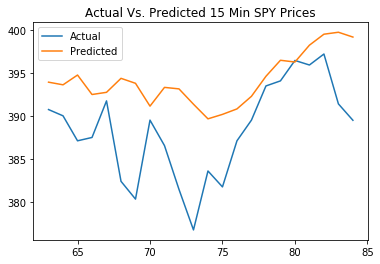

In [69]:
# Plot the real vs predicted prices as a line chart
stocks.plot(title="Actual Vs. Predicted 15 Min SPY Prices")

In [70]:
data2 = data
data2

,time,open,high,low,close,volume,close of tomorrow,RSI,EMA 5,EMA 13,...,crossover_signal_200_800,MACD H,MACD Signal,Predicted,Difference,Avg off,RSI Overbought,RSI Oversold,RSI Long,RSI Short
14,2020-12-04 00:00:00-05:00,367.320,369.850,367.22,369.8300,40264568,369.1200,72.879298,363.940080,362.661607,...,1.0,0.838407,1.0,388.441772,19.321772,15.506843,1.0,0.0,1.0,0.0
15,2020-12-07 00:00:00-05:00,369.020,369.620,367.72,369.1200,40456544,370.1599,70.258587,364.692494,363.245907,...,1.0,0.965118,1.0,387.420502,17.260602,15.506843,1.0,0.0,1.0,0.0
16,2020-12-08 00:00:00-05:00,367.720,370.780,367.67,370.1599,32702217,366.8900,71.854961,365.474310,363.848209,...,1.0,1.101195,1.0,387.789917,20.899917,15.506843,1.0,0.0,1.0,0.0
17,2020-12-09 00:00:00-05:00,370.880,371.050,365.95,366.8900,60700254,366.7200,60.803293,365.674042,364.104181,...,1.0,1.101867,1.0,387.945953,21.225953,15.506843,0.0,0.0,1.0,0.0
18,2020-12-10 00:00:00-05:00,365.370,367.860,364.43,366.7200,47851654,366.2800,60.284166,365.819913,364.317435,...,1.0,1.092560,1.0,389.256866,22.976866,15.506843,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,2021-03-12 00:00:00-05:00,392.070,394.210,391.20,394.0900,56997361,396.4700,59.424072,387.442675,384.776053,...,1.0,4.124959,1.0,381.808716,14.661284,15.506843,0.0,0.0,1.0,0.0
81,2021-03-15 00:00:00-04:00,394.330,396.685,392.03,396.4700,64471980,395.9400,61.545295,388.611271,385.390995,...,1.0,4.480865,1.0,383.474854,12.465146,15.506843,0.0,0.0,1.0,0.0
82,2021-03-16 00:00:00-04:00,397.070,397.830,395.08,395.9400,65719794,397.2200,60.783242,389.559980,385.945360,...,1.0,4.758591,1.0,385.366486,11.853514,15.506843,0.0,0.0,1.0,0.0
83,2021-03-17 00:00:00-04:00,394.530,398.120,393.30,397.2200,61876016,391.4100,62.006774,390.551574,386.537486,...,1.0,5.056076,1.0,386.894623,4.515377,15.506843,0.0,0.0,1.0,0.0


In [71]:
combined_stocks_df = pd.concat([stocks, trained_stocks])
combined_stocks_df.reset_index(inplace=True)
#combined_stocks_df
data2.reset_index(inplace = True)

data2['Predicted'] = combined_stocks_df['Predicted']


C:\Users\jacob\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [72]:
#combined_stocks_df[combined_stocks_df.index.duplicated()]


In [73]:
#data2.dropna(inplace=True)
data2.set_index('time')


,index,open,high,low,close,volume,close of tomorrow,RSI,EMA 5,EMA 13,...,crossover_signal_200_800,MACD H,MACD Signal,Predicted,Difference,Avg off,RSI Overbought,RSI Oversold,RSI Long,RSI Short
time,,,,,,,,,,,,,,,,,,,,,
2020-12-04 00:00:00-05:00,14,367.320,369.850,367.22,369.8300,40264568,369.1200,72.879298,363.940080,362.661607,...,1.0,0.838407,1.0,393.939453,19.321772,15.506843,1.0,0.0,1.0,0.0
2020-12-07 00:00:00-05:00,15,369.020,369.620,367.72,369.1200,40456544,370.1599,70.258587,364.692494,363.245907,...,1.0,0.965118,1.0,393.632904,17.260602,15.506843,1.0,0.0,1.0,0.0
2020-12-08 00:00:00-05:00,16,367.720,370.780,367.67,370.1599,32702217,366.8900,71.854961,365.474310,363.848209,...,1.0,1.101195,1.0,394.771484,20.899917,15.506843,1.0,0.0,1.0,0.0
2020-12-09 00:00:00-05:00,17,370.880,371.050,365.95,366.8900,60700254,366.7200,60.803293,365.674042,364.104181,...,1.0,1.101867,1.0,392.503021,21.225953,15.506843,0.0,0.0,1.0,0.0
2020-12-10 00:00:00-05:00,18,365.370,367.860,364.43,366.7200,47851654,366.2800,60.284166,365.819913,364.317435,...,1.0,1.092560,1.0,392.757690,22.976866,15.506843,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-12 00:00:00-05:00,80,392.070,394.210,391.20,394.0900,56997361,396.4700,59.424072,387.442675,384.776053,...,1.0,4.124959,1.0,389.844208,14.661284,15.506843,0.0,0.0,1.0,0.0
2021-03-15 00:00:00-04:00,81,394.330,396.685,392.03,396.4700,64471980,395.9400,61.545295,388.611271,385.390995,...,1.0,4.480865,1.0,391.327637,12.465146,15.506843,0.0,0.0,1.0,0.0
2021-03-16 00:00:00-04:00,82,397.070,397.830,395.08,395.9400,65719794,397.2200,60.783242,389.559980,385.945360,...,1.0,4.758591,1.0,391.503906,11.853514,15.506843,0.0,0.0,1.0,0.0


In [78]:
data2['Difference'] = abs(data2['close of tomorrow'] - data2['Predicted'])
data2['Avg off'] = data2['Difference'].mean()
print(data2['Avg off'].tail(1))

70    13.477315
Name: Avg off, dtype: float64


C:\Users\jacob\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\jacob\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [79]:
#Lets create a new data frame that records if we should buy or sell based the price of tomorrow's close price
#We will create a column for predicting the price moved up or down Call/Put -- Call = 1 Put = 0
#Using Open, High, Low, Close and Volume here but considered pulling in data from Alphavantage and include more data as parameters -- train both multiple classification models and determine which is best 
#Consider training Random Forrest Model to predict call or put - taraget will be call/put - features can be all data than can be pulled except close of tomorrow and predicted
signals_df = data2.drop(columns=['Difference', 'Avg off'])
signals_df['Call/Put'] = np.where(signals_df['close'] < signals_df['close of tomorrow'], 1, 0)
signals_df


,index,time,open,high,low,close,volume,close of tomorrow,RSI,EMA 5,...,crossover_short_200_800,crossover_signal_200_800,MACD H,MACD Signal,Predicted,RSI Overbought,RSI Oversold,RSI Long,RSI Short,Call/Put
0,14,2020-12-04 00:00:00-05:00,367.320,369.850,367.22,369.8300,40264568,369.1200,72.879298,363.940080,...,0.0,1.0,0.838407,1.0,393.939453,1.0,0.0,1.0,0.0,0
1,15,2020-12-07 00:00:00-05:00,369.020,369.620,367.72,369.1200,40456544,370.1599,70.258587,364.692494,...,0.0,1.0,0.965118,1.0,393.632904,1.0,0.0,1.0,0.0,1
2,16,2020-12-08 00:00:00-05:00,367.720,370.780,367.67,370.1599,32702217,366.8900,71.854961,365.474310,...,0.0,1.0,1.101195,1.0,394.771484,1.0,0.0,1.0,0.0,0
3,17,2020-12-09 00:00:00-05:00,370.880,371.050,365.95,366.8900,60700254,366.7200,60.803293,365.674042,...,0.0,1.0,1.101867,1.0,392.503021,0.0,0.0,1.0,0.0,0
4,18,2020-12-10 00:00:00-05:00,365.370,367.860,364.43,366.7200,47851654,366.2800,60.284166,365.819913,...,0.0,1.0,1.092560,1.0,392.757690,0.0,0.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,80,2021-03-12 00:00:00-05:00,392.070,394.210,391.20,394.0900,56997361,396.4700,59.424072,387.442675,...,0.0,1.0,4.124959,1.0,389.844208,0.0,0.0,1.0,0.0,1
67,81,2021-03-15 00:00:00-04:00,394.330,396.685,392.03,396.4700,64471980,395.9400,61.545295,388.611271,...,0.0,1.0,4.480865,1.0,391.327637,0.0,0.0,1.0,0.0,0
68,82,2021-03-16 00:00:00-04:00,397.070,397.830,395.08,395.9400,65719794,397.2200,60.783242,389.559980,...,0.0,1.0,4.758591,1.0,391.503906,0.0,0.0,1.0,0.0,1
69,83,2021-03-17 00:00:00-04:00,394.530,398.120,393.30,397.2200,61876016,391.4100,62.006774,390.551574,...,0.0,1.0,5.056076,1.0,392.776855,0.0,0.0,1.0,0.0,0


In [80]:
#define feauture and target values
X2 = signals_df[['open', 'high', 'low', 'close', 'volume', 'RSI Overbought', 'RSI Oversold', 'RSI Long', 'RSI Short', 'crossover_signal_5_13', 'crossover_long_5_13', 'crossover_short_5_13', 'crossover_signal_9_21', 'crossover_long_9_21', 'crossover_short_9_21', 'crossover_signal_55_200', 'crossover_long_55_200', 'crossover_short_55_200', 'crossover_signal_200_800', 'crossover_long_200_800', 'crossover_short_200_800', 'MACD Signal']]
y2 = signals_df[['Call/Put']]

X2 = np.array(X2)
y2 = np.array(y2)

# Use 70% of the data for training and the remaineder for testing
split = int(0.7 * len(X2))
X_train = X2[: split]
X_test = X2[split:]
y_train = y2[: split]
y_test = y2[split:]

In [81]:
signals_df

,index,time,open,high,low,close,volume,close of tomorrow,RSI,EMA 5,...,crossover_short_200_800,crossover_signal_200_800,MACD H,MACD Signal,Predicted,RSI Overbought,RSI Oversold,RSI Long,RSI Short,Call/Put
0,14,2020-12-04 00:00:00-05:00,367.320,369.850,367.22,369.8300,40264568,369.1200,72.879298,363.940080,...,0.0,1.0,0.838407,1.0,393.939453,1.0,0.0,1.0,0.0,0
1,15,2020-12-07 00:00:00-05:00,369.020,369.620,367.72,369.1200,40456544,370.1599,70.258587,364.692494,...,0.0,1.0,0.965118,1.0,393.632904,1.0,0.0,1.0,0.0,1
2,16,2020-12-08 00:00:00-05:00,367.720,370.780,367.67,370.1599,32702217,366.8900,71.854961,365.474310,...,0.0,1.0,1.101195,1.0,394.771484,1.0,0.0,1.0,0.0,0
3,17,2020-12-09 00:00:00-05:00,370.880,371.050,365.95,366.8900,60700254,366.7200,60.803293,365.674042,...,0.0,1.0,1.101867,1.0,392.503021,0.0,0.0,1.0,0.0,0
4,18,2020-12-10 00:00:00-05:00,365.370,367.860,364.43,366.7200,47851654,366.2800,60.284166,365.819913,...,0.0,1.0,1.092560,1.0,392.757690,0.0,0.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,80,2021-03-12 00:00:00-05:00,392.070,394.210,391.20,394.0900,56997361,396.4700,59.424072,387.442675,...,0.0,1.0,4.124959,1.0,389.844208,0.0,0.0,1.0,0.0,1
67,81,2021-03-15 00:00:00-04:00,394.330,396.685,392.03,396.4700,64471980,395.9400,61.545295,388.611271,...,0.0,1.0,4.480865,1.0,391.327637,0.0,0.0,1.0,0.0,0
68,82,2021-03-16 00:00:00-04:00,397.070,397.830,395.08,395.9400,65719794,397.2200,60.783242,389.559980,...,0.0,1.0,4.758591,1.0,391.503906,0.0,0.0,1.0,0.0,1
69,83,2021-03-17 00:00:00-04:00,394.530,398.120,393.30,397.2200,61876016,391.4100,62.006774,390.551574,...,0.0,1.0,5.056076,1.0,392.776855,0.0,0.0,1.0,0.0,0


In [82]:
#X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
#X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
y_test

array([[0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0]])

In [83]:
from sklearn.ensemble import RandomForestClassifier
# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
model = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0)
model.fit(X_train, y_train)

# Make a prediction of "y" values from the X_test dataset
predictions = model.predict(X_test)

# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
Results = pd.DataFrame({'results': y_test.ravel()})

Results["Predicted Value"] = predictions
Results

C:\Users\jacob\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


,results,Predicted Value
0,0,1
1,0,1
2,0,1
3,1,1
4,1,1
5,0,1
6,0,1
7,1,1
8,0,1
9,0,1


In [84]:
#evaulute model performance 
from sklearn.metrics import confusion_matrix, classification_report

y_pred = model.predict(X_test)
confusion_matrix(y_test, y_pred)


#print(classification_report(y_test, y_pred))

array([[ 0, 12],
       [ 0, 10]], dtype=int64)